In [1]:
# import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

np.random.seed(88)

***

# Step 1: Generate Data

In [2]:
# Parameters
num_classes = 8
examples_per_class = 50
feature_dim = 128  # Dimensionality of the feature vectors
noise_variance = 1  # Variance of the noise

# generate synthetic data (with `num_classes` centers, each with 50 samples)
centers = np.random.uniform(-1, 1, (num_classes, feature_dim))
data = []
labels = []
for i in range(num_classes):
    noise = np.random.normal(0, noise_variance, (examples_per_class, feature_dim))
    examples = centers[i] + noise # add random noise around centre 
    data.append(examples)
    labels += [i] * examples_per_class

data = np.vstack(data).astype(np.float32)
labels = np.array(labels)

In [3]:
def visualise(data:np.ndarray, labels:np.ndarray, title=None):
    """
    Visualise high dimension (>2 dim) data on 2D plane using t-sne
    """
    assert data.shape[0] == labels.shape[0], "Number of samples & labels do not match"
    
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=42) 
    data_2d = tsne.fit_transform(data)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Class label')
    
    if title is None:
        plt.title('t-SNE Visualization of the Dataset')
    else:
        plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

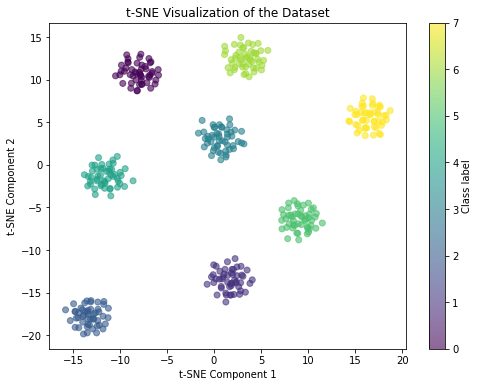

In [4]:
visualise(data, labels)

# Step 2: Define Optimization Objective (model & loss)

In [5]:
# define model
class SimpleModel(nn.Module):
    """
    Simple 2 layer models that takes in inputs (with `feat_dim` dimensions) and output an embedding (with `feat_dim` dimensions)
    """
    def __init__(self, feat_dim):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(feat_dim, 256)  
        self.fc2 = nn.Linear(256, feat_dim)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
# define loss
class ArcFaceLoss(nn.Module):
    """
    Adapted from: https://github.com/JDAI-CV/FaceX-Zoo/blob/main/head/ArcFace.py 
    """
    def __init__(self, feat_dim, num_class, margin_arc=0.9, margin_am=0.0, scale=32):
        super(ArcFaceLoss, self).__init__()
        
        # last fully connected layer that maps feature embeddings to `num_class` logits
        self.weight = nn.Parameter(torch.Tensor(feat_dim, num_class))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)
        
        # arcface margin config
        self.margin_arc = margin_arc
        self.margin_am = margin_am
        self.scale = scale
        self.cos_margin = math.cos(margin_arc)
        self.sin_margin = math.sin(margin_arc)
        self.min_cos_theta = math.cos(math.pi - margin_arc)
        
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, feats, labels):
        kernel_norm = F.normalize(self.weight, dim=0)
        feats = F.normalize(feats)
        cos_theta = torch.mm(feats, kernel_norm) 
        cos_theta = cos_theta.clamp(-1, 1)
        sin_theta = torch.sqrt(1.0 - torch.pow(cos_theta, 2))
        cos_theta_m = cos_theta * self.cos_margin - sin_theta * self.sin_margin
        cos_theta_m = torch.where(cos_theta > self.min_cos_theta, cos_theta_m, cos_theta-self.margin_am)
        index = torch.zeros_like(cos_theta)
        index.scatter_(1, labels.data.view(-1, 1), 1)
        index = index.byte().bool()
        output = cos_theta * 1.0
        output[index] = cos_theta_m[index]
        output *= self.scale
        
        return self.loss_fn(output, labels)
    
class CrossEntropyLoss(nn.Module):
    def __init__(self, feat_dim, num_class):
        super(CrossEntropyLoss, self).__init__()
        # last fully connected layer that maps feature embeddings to `num_class` logits
        self.weight = nn.Parameter(torch.Tensor(feat_dim, num_class))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5) 
        
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, feats, labels):
        kernel_norm = F.normalize(self.weight, dim=0)
        feats = F.normalize(feats)
        
        logits = torch.mm(feats, kernel_norm)
        return self.loss_fn(logits, labels)

In [7]:
# testing
arc_face_loss = ArcFaceLoss(feat_dim=128, num_class=8)
cross_entropy_loss = CrossEntropyLoss(feat_dim=128, num_class=8)

print(arc_face_loss(torch.from_numpy(data), torch.from_numpy(labels)))
print(cross_entropy_loss(torch.from_numpy(data), torch.from_numpy(labels)))

tensor(29.1182, grad_fn=<NllLossBackward0>)
tensor(2.0555, grad_fn=<NllLossBackward0>)


****

# Step 3: Training Model

In [8]:
def train(x_tensor, y_tensor, model, criterion, optimizer):
    """
    Simple training loop
    """
    num_epochs = 500
    
    for epoch in range(num_epochs):
        model.train()

        # forward pass
        outputs = model(x_tensor)
        loss = criterion(outputs, y_tensor)

        # backpropagation and update weights 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training loss 
        if (epoch + 1) % 50 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss}')
    
    return model

In [9]:
# training dataset
x_tensor = torch.from_numpy(data)
y_tensor = torch.from_numpy(labels)

In [10]:
# Setting 1: Using CrossEntropyLoss
model1 = SimpleModel(feat_dim=128)
criterion1 = CrossEntropyLoss(feat_dim=128, num_class=8)
optimizer1 = optim.SGD(model1.parameters(), lr=0.001, momentum=0.8)

model1 = train(x_tensor, y_tensor, model1, criterion1, optimizer1) 

Epoch 50, Loss: 2.041301965713501
Epoch 100, Loss: 1.998195767402649
Epoch 150, Loss: 1.9541749954223633
Epoch 200, Loss: 1.9089561700820923
Epoch 250, Loss: 1.8627933263778687
Epoch 300, Loss: 1.8166024684906006
Epoch 350, Loss: 1.7717759609222412
Epoch 400, Loss: 1.7297459840774536
Epoch 450, Loss: 1.6914886236190796
Epoch 500, Loss: 1.657332181930542


In [11]:
# Setting 1: Using ArcFace Loss
model2 = SimpleModel(feat_dim=128)
criterion2 = ArcFaceLoss(feat_dim=128, num_class=8)
optimizer2 = optim.SGD(model2.parameters(), lr=0.001, momentum=0.8)

model2 = train(x_tensor, y_tensor, model2, criterion2, optimizer2) 

Epoch 50, Loss: 7.128726005554199
Epoch 100, Loss: 0.21364955604076385
Epoch 150, Loss: 0.05264080688357353
Epoch 200, Loss: 0.031615398824214935
Epoch 250, Loss: 0.023249218240380287
Epoch 300, Loss: 0.018626905977725983
Epoch 350, Loss: 0.015657683834433556
Epoch 400, Loss: 0.013573664240539074
Epoch 450, Loss: 0.012022392824292183
Epoch 500, Loss: 0.01081873383373022


***

# Step 4: Visualise Model Output Embeddings

In [12]:
pred1 = model1(x_tensor).detach().numpy()
pred2 = model2(x_tensor).detach().numpy()

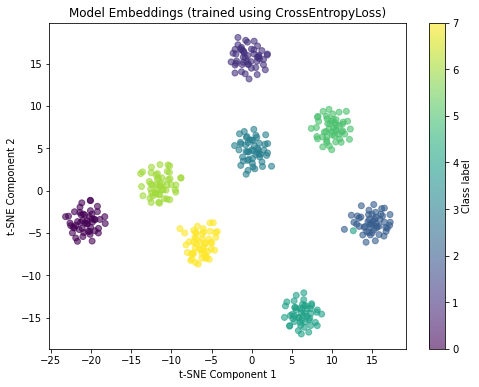

In [13]:
visualise(pred1, labels, title="Model Embeddings (trained using CrossEntropyLoss)")

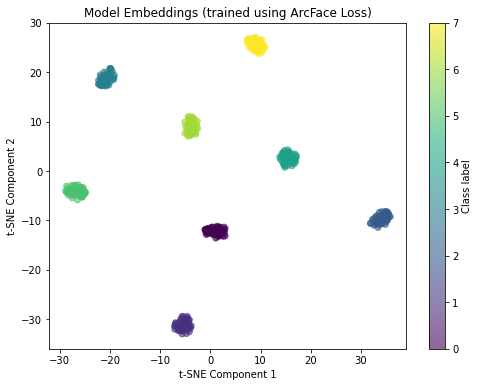

In [14]:
visualise(pred2, labels, title="Model Embeddings (trained using ArcFace Loss)")